In [1]:
%matplotlib inline
from pyqubo import Spin, Array, Placeholder, Constraint
import matplotlib.pyplot as plt
import networkx as nx

## Graph Partitioning Problem

Partition a graph into two equal size parts such that the number of divided edges are minimized. Ising formulation of this problem is represented as

$$
H(s) = \alpha H_{A}(s) + H_{B}(s)\\
H_{A}(s) = \left( \sum_{i \in V} s_{i}\right )^2\\
H_{B}(s) = \sum_{(i, j) \in E} \frac{1-s_{i}s_{j}}{2}
$$

$H_{A}(s)$ is a constraint that two graph has equal number of nodes. $H_{B}(s)$ is the number of divided edges. $\alpha$ is a penalty strength.

In [2]:
def plot_graph(E, colors=None):
    G = nx.Graph()
    for (i, j) in E:
        G.add_edge(i, j)
    plt.figure(figsize=(4,4))
    pos = nx.spring_layout(G)
    if colors:
        nx.draw_networkx(G, pos, node_color=[colors[node] for node in G.nodes])
    else:
        nx.draw_networkx(G, pos)
    plt.axis("off")
    plt.show()

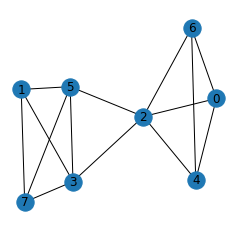

In [3]:
# Following edges are given
E = {(0, 6), (2, 4), (7, 5), (0, 4), (2, 0),
     (5, 3), (2, 3), (2, 6), (4, 6), (1, 3),
     (1, 5), (7, 1), (7, 3), (2, 5)}
plot_graph(E)

Prepare a vector with 8 dimension. Each spin represents which group it belongs to.

In [4]:
# Define spin vector
s = Array.create("s", 8, 'SPIN')

# Define placeholder alpha
a = Placeholder("alpha")

In [5]:
# Define hamiltonian H_{A}
HA =Constraint(sum(s) ** 2, "num_nodes")

# Define hamiltonian H_{B}
HB = sum((1.0 - s[i]*s[j]) / 2.0 for (i, j) in E)

H = a * HA + HB

In [6]:
# Compile model
model = H.compile()

# Create Ising model with alpha = 0.1
feed_dict={'alpha': 0.1}
bqm = model.to_bqm(feed_dict=feed_dict)

In [8]:
# Solve Ising model
import neal
sa = neal.SimulatedAnnealingSampler()
sampleset = sa.sample(bqm)

# Decode solution
decoded_samples = model.decode_sampleset(sampleset, feed_dict=feed_dict)
best_sample = min(decoded_samples, key=lambda x: x.energy)

print("#broken constraints: {}".format(len(best_sample.constraints(only_broken=True))))

#broken constraints: 0


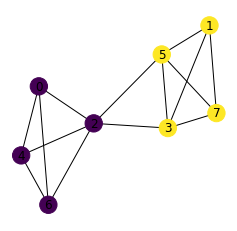

In [9]:
# Plot graph
plot_graph(E, [best_sample.sample[k]+1 for k in sorted(best_sample.sample.keys())])